In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
import random
from sklearn.utils import resample


In [ ]:
data=pd.read_csv('mnli.tsv',sep='\t',header=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data=data.rename(columns={0: "id", 1: "premise", 2: "entailment", 3: "target"})

In [ ]:
data.head()

,id,premise,entailment,target
0,190,you know and held over for trial,Released and no trial.,0
1,317,um-hum yeah i end up well yeah i mean i do a l...,I don't mind camping for a couple nights in th...,0
2,344,"When he married in 1901, he and his wife (Olga...",His wife has never went to a sanitarium.,0
3,349,but uh what's that,"However, what is that?",0
4,362,You outwitted me.,You have never outwitted me.,0


In [ ]:
print(data['target'].value_counts())

0    362013
1      2002
Name: target, dtype: int64


In [ ]:
# Separate majority and minority classes
df_majority = data[data['target']==0]
df_minority = data[data['target']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=2002)
data = pd.concat([df_majority_downsampled,df_minority])
#df = resample(df_minority, replace = False, n_samples = 100)
#df.to_csv('/content/drive/My Drive/outlierMNLI.csv')          

In [ ]:
target=data['target']
data = data.drop(['id'],axis=1)

In [ ]:
data.head()

,premise,entailment,target
268650,Although what happens seems to be up to Starr ...,All of the matters are in Starr's hands now.,0
88026,i'm not saying they're all bad but i think peo...,"Every person, regardless of the crime, should ...",0
203938,The man nodded as Hanson dropped down beside him.,"The man shook his head, and Hanson kept standi...",0
247060,and uh and there's uh a lot of trees lot of mo...,We did not have a clipper sail boat.,0
316906,Early in the construction phase a formal const...,Early in the construction phase a formal const...,0


In [ ]:
import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla P100-PCIE-16GB, n_gpu: 1


In [ ]:
!pip install transformers
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
print('success!')

import os
import zipfile

# Download helper functions file
helper_file = drive.CreateFile({'id': '16HW-z9Y1tM3gZ_vFpJAuwUDohz91Aac-'})
helper_file.GetContentFile('helpers.py')
print('helper file downloaded! (helpers.py)')


success!
helper file downloaded! (helpers.py)


In [ ]:
from transformers import BertTokenizer
def load_data(df):
  MAX_LEN = 512
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  token_ids = []
  mask_ids = []
  seg_ids = []
  y = []

  premise_list = df['premise'].to_list()
  entailment_list = df['entailment'].to_list()
  label_list = df['target'].to_list()

  for (premise, hypothesis, label) in zip(premise_list, entailment_list, label_list):
    premise=premise[:MAX_LEN]
    hypothesis=hypothesis[:MAX_LEN]
    premise_id = tokenizer.encode(premise, add_special_tokens = False)
    hypothesis_id = tokenizer.encode(hypothesis, add_special_tokens = False)
    pair_token_ids = [tokenizer.cls_token_id] + premise_id + [tokenizer.sep_token_id] + hypothesis_id + [tokenizer.sep_token_id]
    premise_len = len(premise_id)
    hypothesis_len = len(hypothesis_id)

    segment_ids = torch.tensor([0] * (premise_len + 2) + [1] * (hypothesis_len + 1))  # sentence 0 and sentence 1
    attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values

    token_ids.append(torch.tensor(pair_token_ids))
    seg_ids.append(segment_ids)
    mask_ids.append(attention_mask_ids)
    y.append(label)
    
  token_ids = pad_sequence(token_ids, batch_first=True)
  mask_ids = pad_sequence(mask_ids, batch_first=True)
  seg_ids = pad_sequence(seg_ids, batch_first=True)
  y = torch.tensor(y)
  dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
  print(len(dataset))
  return dataset


In [ ]:
def get_data_loaders(batch_size=32, shuffle=True):
  train_loader = DataLoader(
    train_data,
    shuffle=shuffle,
    batch_size=batch_size
  )

  val_loader = DataLoader(
    val_data,
    shuffle=shuffle,
    batch_size=batch_size
  )

  return train_loader, val_loader

In [ ]:
 from sklearn.model_selection import train_test_split

 X_train, X_val = train_test_split(data,test_size=0.2, random_state=1)

In [ ]:
train_data = load_data(X_train)
val_data = load_data(X_val)

3203
801


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
batch_size = 32
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 2e-8 # args.adam_epsilon  - default is 1e-8
                )
epochs = 5

In [ ]:
from sklearn.metrics import f1_score
def multi_acc(y_pred, y_test):
  pred = torch.log_softmax(y_pred, dim=1).argmax(dim=1)
  acc = (pred == y_test).sum().float() / float(y_test.size(0))
  #print(f1_score(y_test.cpu().numpy(),pred.cpu().numpy()))
  return acc

import time

EPOCHS = 5

def train(model, train_loader, val_loader, optimizer):  
  total_step = len(train_loader)

  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)

      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

      acc = multi_acc(prediction, labels)

      loss.backward()
      optimizer.step()
      
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    model.eval()
    total_val_acc  = 0
    total_val_loss = 0
    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)
        
        loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
        
        acc = multi_acc(prediction, labels)

        total_val_loss += loss.item()
        total_val_acc  += acc.item()

    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [ ]:
train_loader = DataLoader(train_data,shuffle=True,batch_size=16)
val_loader = DataLoader(val_data,shuffle=True,batch_size=16)

In [ ]:
train(model, train_loader, val_loader, optimizer)

Epoch 1: train_loss: 0.7013 train_acc: 0.4862 | val_loss: 0.6958 val_acc: 0.4792
00:01:00.76
Epoch 2: train_loss: 0.6911 train_acc: 0.5358 | val_loss: 0.6966 val_acc: 0.5319
00:01:00.65
Epoch 3: train_loss: 0.6160 train_acc: 0.6587 | val_loss: 0.7623 val_acc: 0.5172
00:01:00.66
Epoch 4: train_loss: 0.2998 train_acc: 0.8828 | val_loss: 1.1255 val_acc: 0.5086
00:01:00.64
Epoch 5: train_loss: 0.0745 train_acc: 0.9782 | val_loss: 1.6293 val_acc: 0.5012
00:01:00.76


In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import sklearn
from sklearn.metrics import roc_auc_score

from sklearn.metrics import f1_score

def multi_acc(y_pred, y_test,total_roc,num_iter):
  pred = torch.log_softmax(y_pred, dim=1).argmax(dim=1)
  probs = torch.argmax(y_pred,axis=1)
  
  print('pred',pred)
  acc = (pred == y_test).sum().float() / float(y_test.size(0))
  print('prob',probs)
  
  fpr, tpr, thresholds = roc_curve(y_test.cpu().numpy(), probs.cpu().numpy())
  
  pyplot.plot([0, 1], [0, 1], linestyle='--')
  pyplot.plot(fpr, tpr)
  pyplot.show()
  #roc_acc = roc_auc_score(y_test.cpu().numpy(),probs.cpu().numpy())
  #print(f1_score(y_test.cpu().numpy(),pred.cpu().numpy()))
  try:
    roc_auc= roc_auc_score(y_test.cpu().numpy(), probs.cpu().numpy())
    total_roc+=roc_auc
    print('roc',roc_auc)
    num_iter+=1
  except ValueError:
    pass
  
  return acc,total_roc,num_iter

import time

EPOCHS = 1




def train(model, train_loader, val_loader, optimizer):  
  total_step = len(train_loader)

  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    total_roc_1 = 0
    number_of_iter = 0
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)

      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

      acc,train_roc,iter_1 = multi_acc(prediction, labels,total_roc_1,number_of_iter)
      
      #roc_acc = roc_auc_score(labels,prediction,multi_class='ovr')
      #acc = sklearn.accuracy_score(labels,prediction)
      print('acc1',acc)
      loss.backward()
      optimizer.step()
      
      total_train_loss += loss.item()
      total_train_acc  += acc.item()
      

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    model.eval()
    total_val_acc  = 0
    total_val_loss = 0
    total_roc = 0
    number_of_iter=0

    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)
        
        loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
        
        acc,roc,iter = multi_acc(prediction, labels,total_roc,number_of_iter)
        #acc = sklearn.accuracy_score(labels,prediction)
        total_val_loss += loss.item()
        total_val_acc  += acc.item()
        number_of_iter +=iter
        total_roc +=roc
        

    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    print('roc',roc)
    print('num',number_of_iter)
    print('avg',roc/number_of_iter)


pred tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')


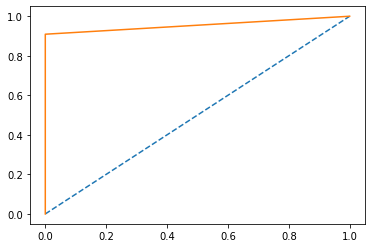

roc 0.9545454545454546
acc1 tensor(0.9375, device='cuda:0')
pred tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
prob tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')


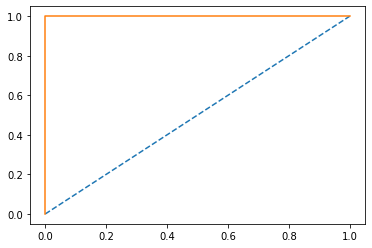

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')


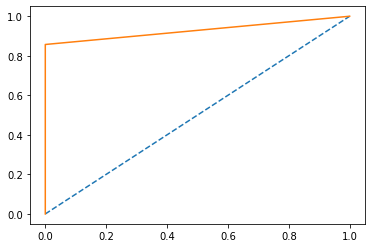

roc 0.9285714285714286
acc1 tensor(0.9375, device='cuda:0')
pred tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')


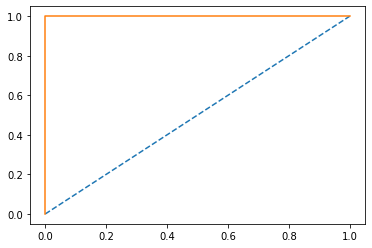

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


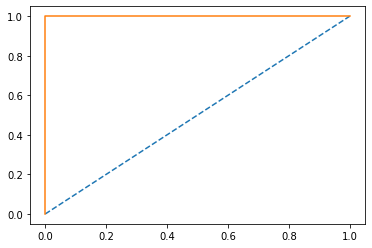

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
prob tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')


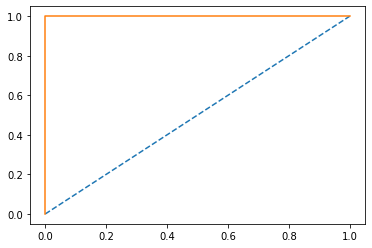

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')


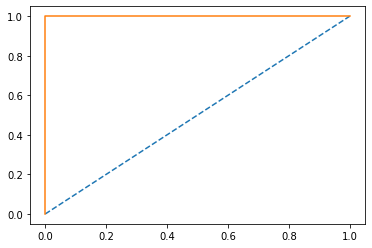

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
prob tensor([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')


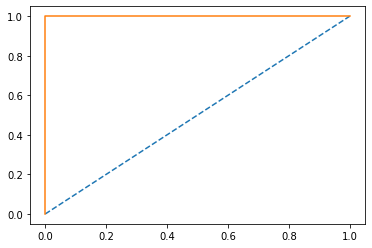

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')


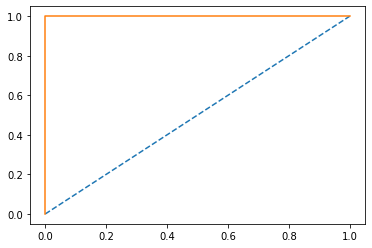

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')


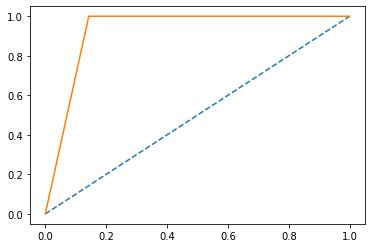

roc 0.9285714285714286
acc1 tensor(0.9375, device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')


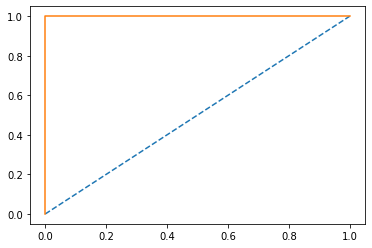

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
prob tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')


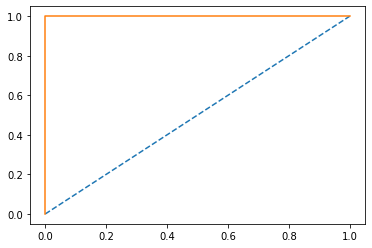

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
prob tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')


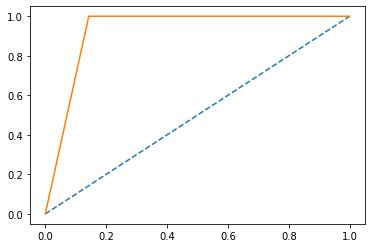

roc 0.9285714285714286
acc1 tensor(0.9375, device='cuda:0')
pred tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
prob tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')


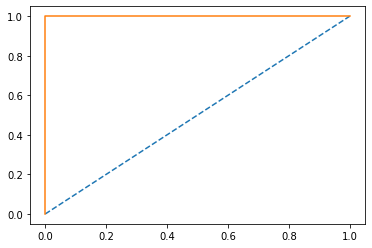

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')


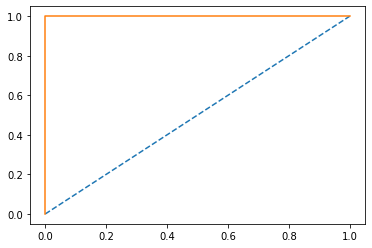

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
prob tensor([1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')


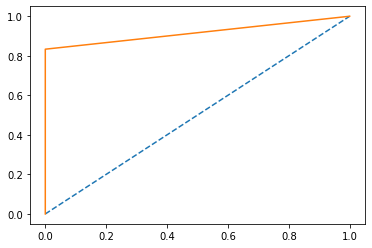

roc 0.9166666666666667
acc1 tensor(0.8750, device='cuda:0')
pred tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')


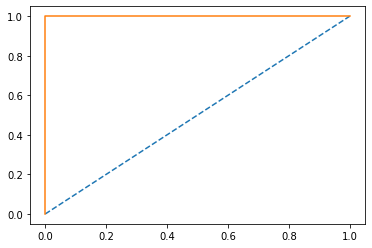

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
prob tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')


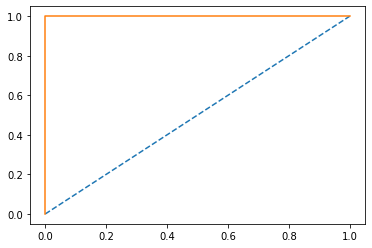

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
prob tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')


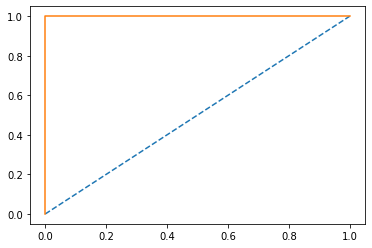

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')


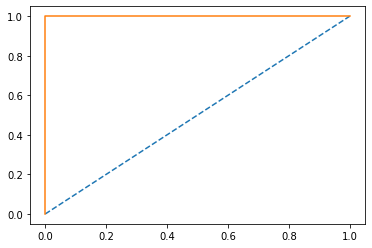

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')


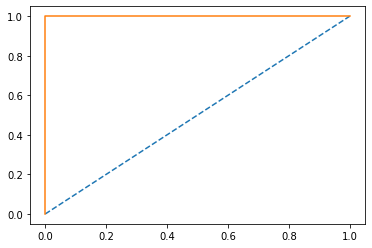

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')


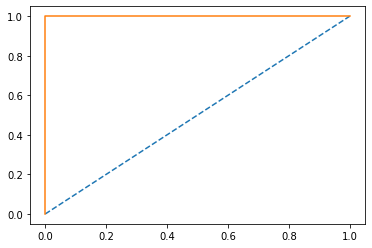

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')


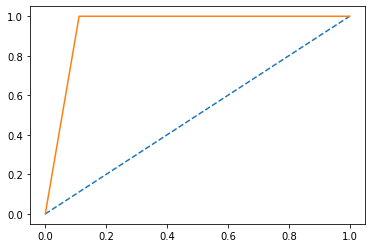

roc 0.9444444444444444
acc1 tensor(0.9375, device='cuda:0')
pred tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
prob tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')


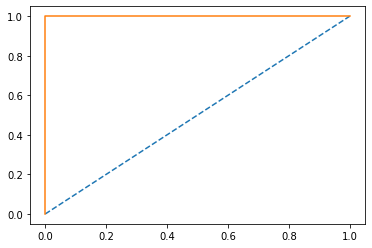

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')


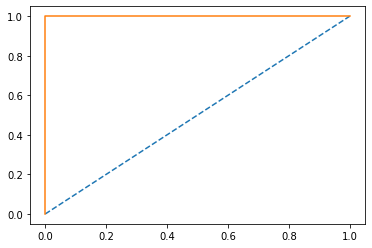

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')


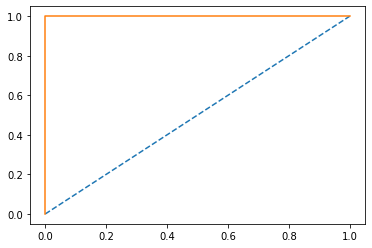

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')


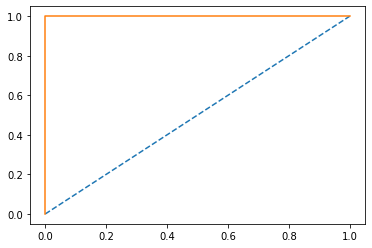

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')


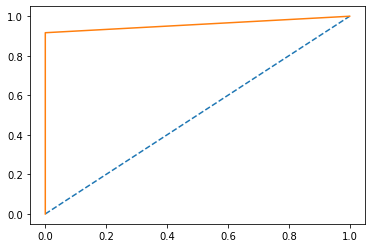

roc 0.9583333333333333
acc1 tensor(0.9375, device='cuda:0')
pred tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
prob tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')


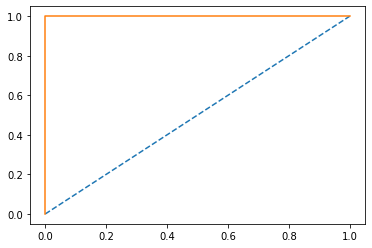

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')


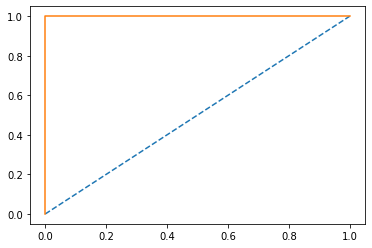

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')


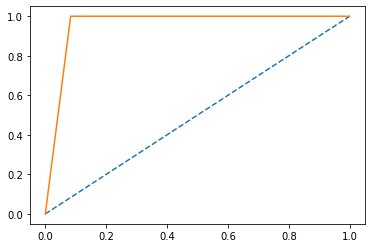

roc 0.9583333333333333
acc1 tensor(0.9375, device='cuda:0')
pred tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')


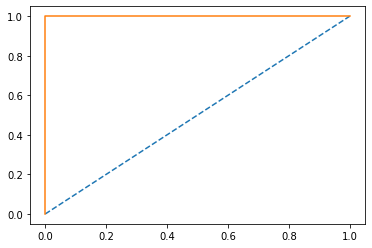

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
prob tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')


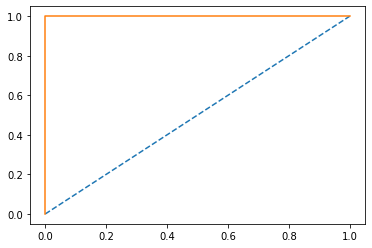

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
prob tensor([1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')


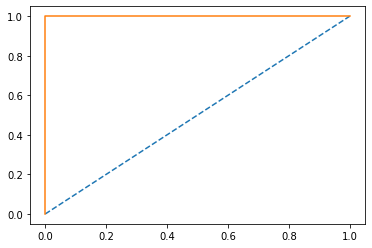

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
prob tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')


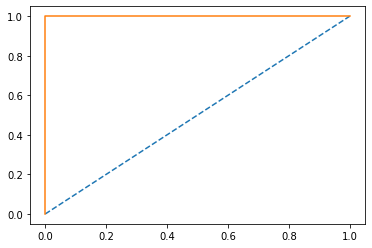

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
prob tensor([1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')


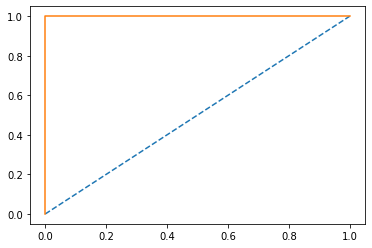

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')


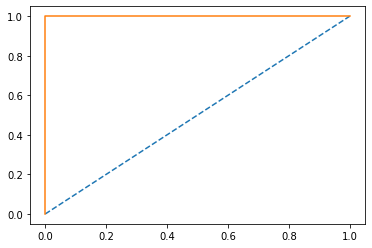

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')


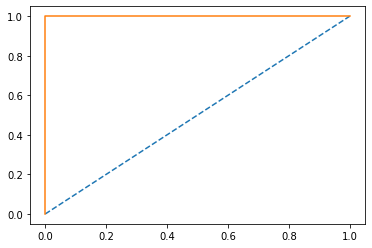

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')


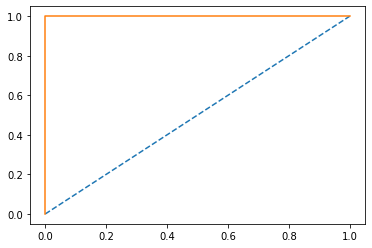

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')


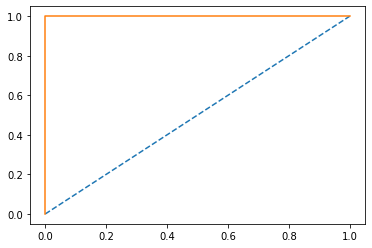

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')


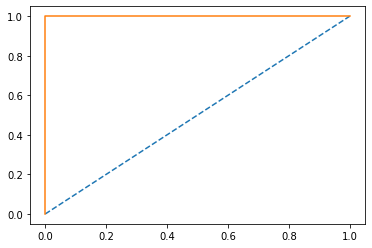

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')


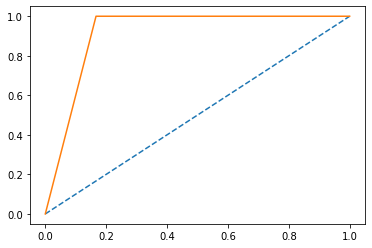

roc 0.9166666666666667
acc1 tensor(0.9375, device='cuda:0')
pred tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')


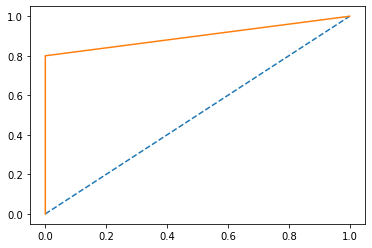

roc 0.9
acc1 tensor(0.9375, device='cuda:0')
pred tensor([1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')


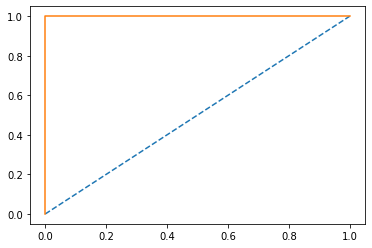

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')


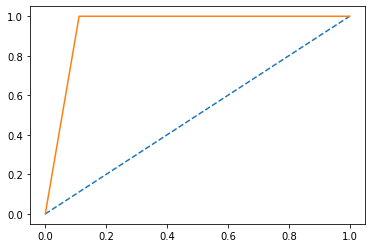

roc 0.9444444444444444
acc1 tensor(0.9375, device='cuda:0')
pred tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')


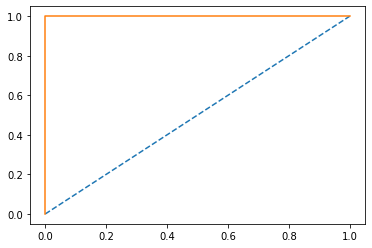

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
prob tensor([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')


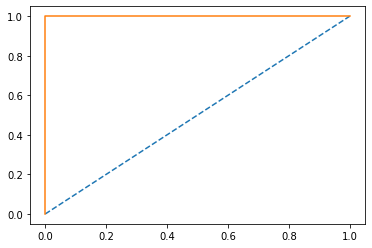

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')


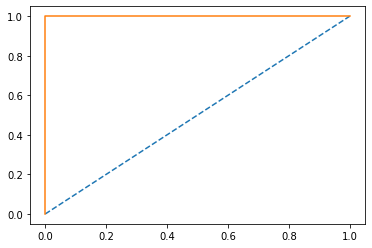

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
prob tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')


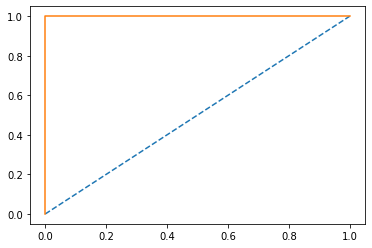

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')


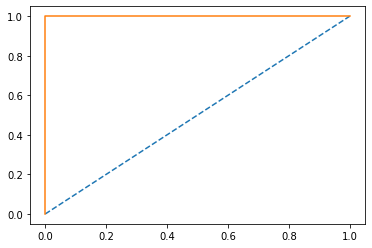

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')


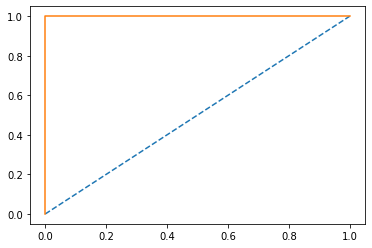

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
prob tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')


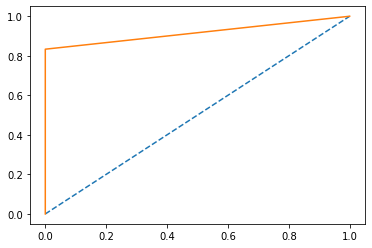

roc 0.9166666666666667
acc1 tensor(0.9375, device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')


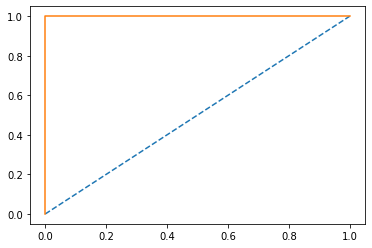

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')


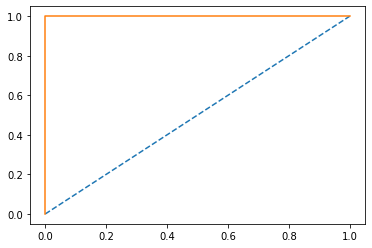

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')


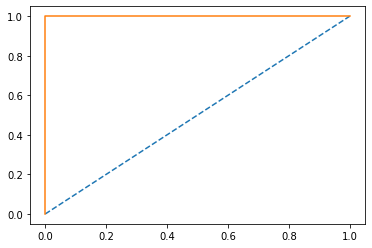

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')


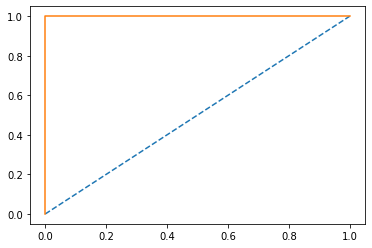

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')


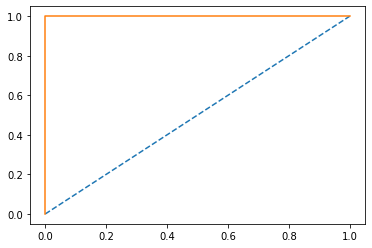

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')


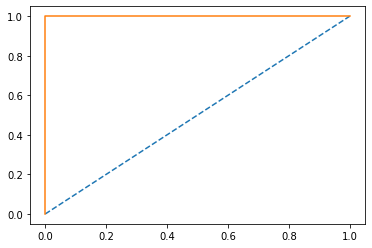

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')


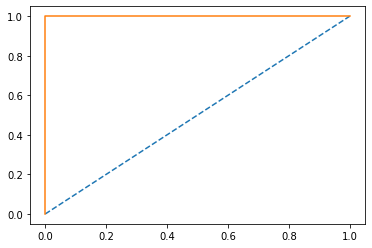

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
prob tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')


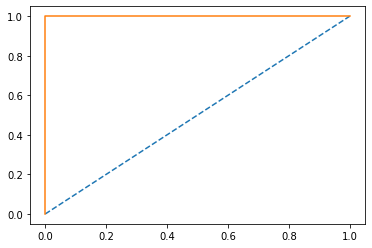

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')


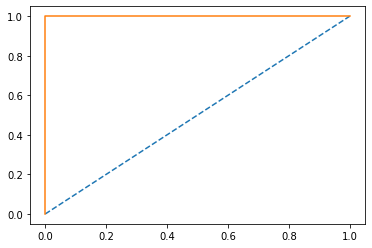

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')


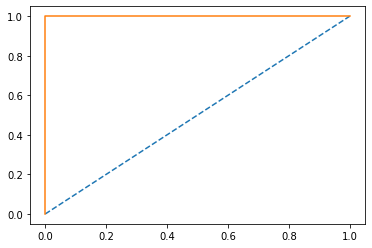

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')


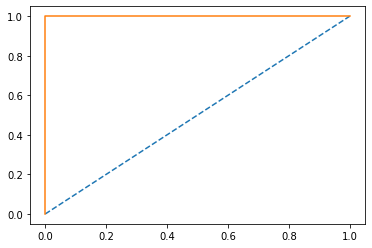

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')


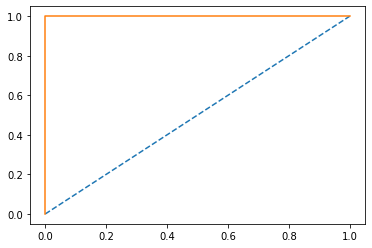

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
prob tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')


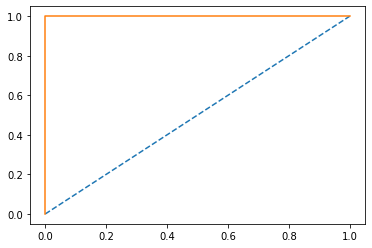

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')


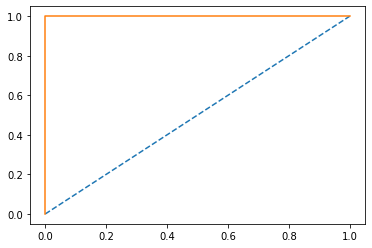

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
prob tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')


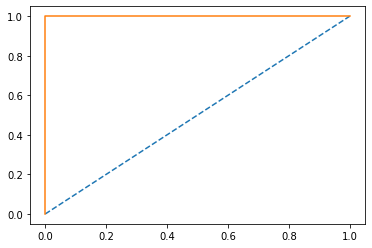

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
prob tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')


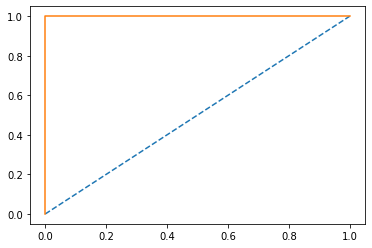

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')


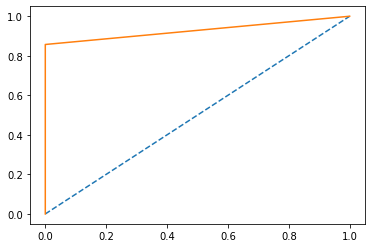

roc 0.9285714285714286
acc1 tensor(0.9375, device='cuda:0')
pred tensor([0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
prob tensor([0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')


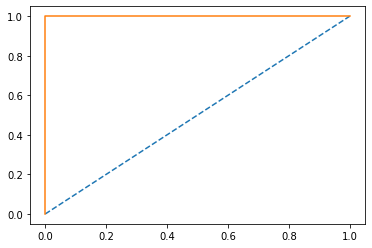

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')


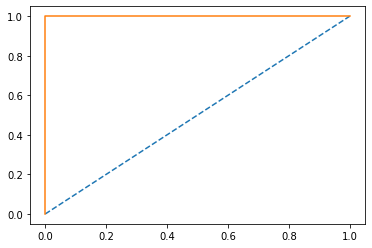

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')


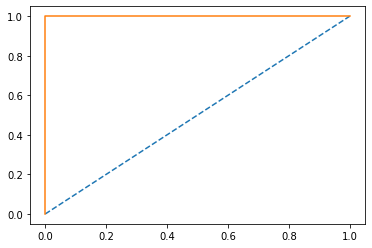

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')


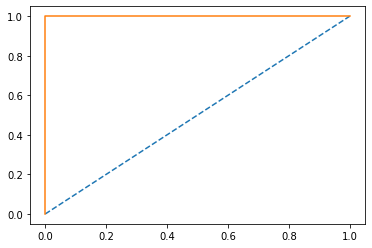

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')


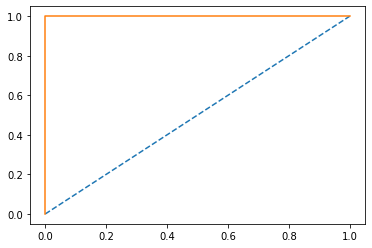

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')


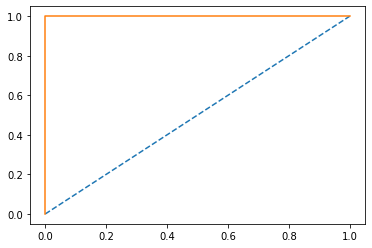

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')


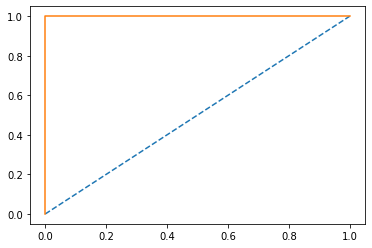

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')


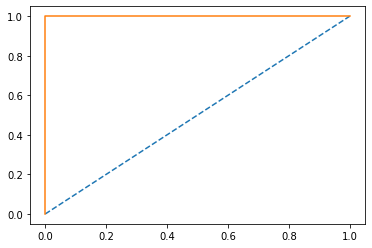

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
prob tensor([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')


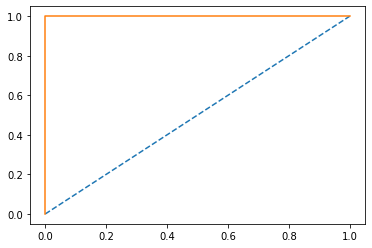

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')


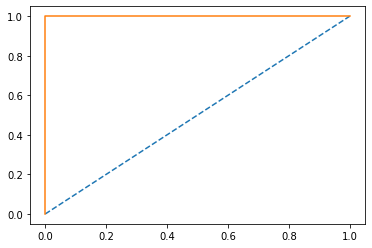

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
prob tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')


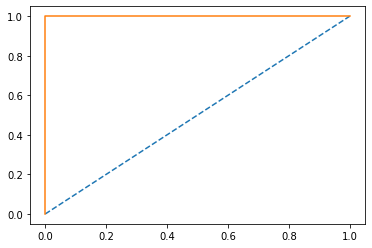

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')


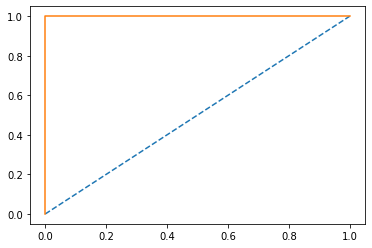

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')


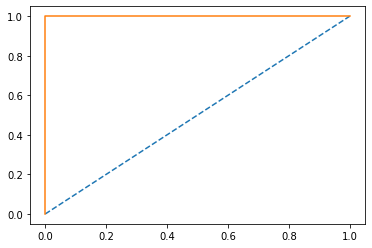

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')


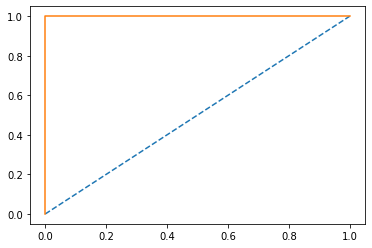

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')


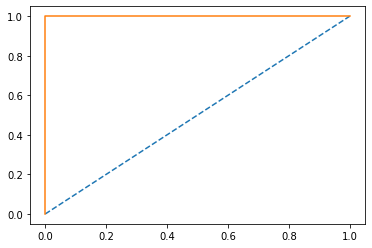

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
prob tensor([0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')


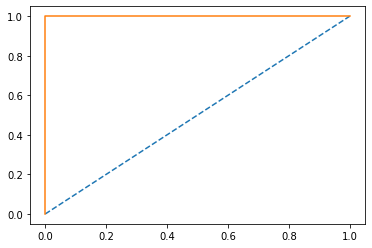

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')


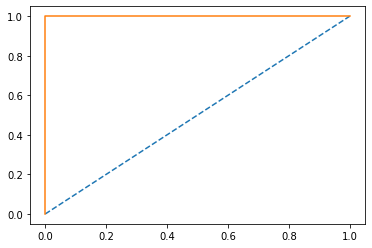

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')


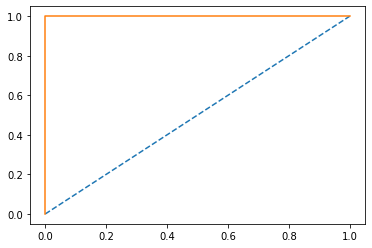

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


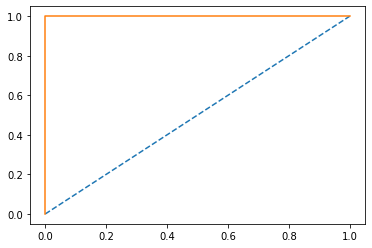

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')


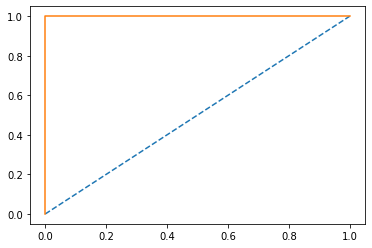

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')


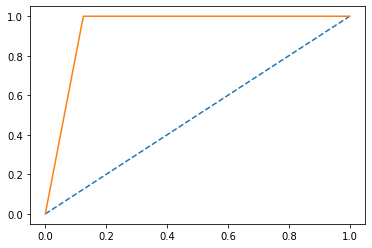

roc 0.9375
acc1 tensor(0.9375, device='cuda:0')
pred tensor([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')


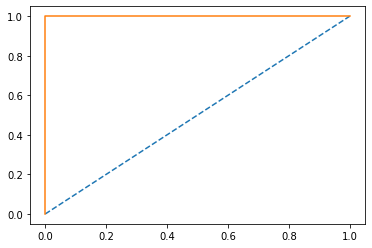

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')


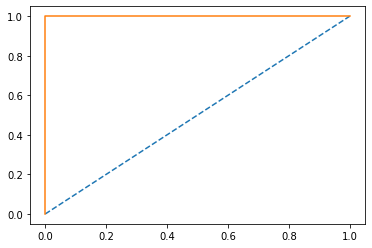

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
prob tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')


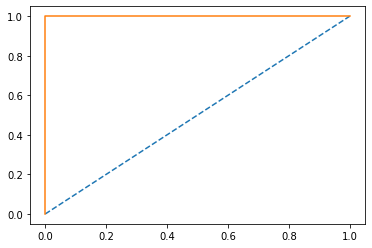

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
prob tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')


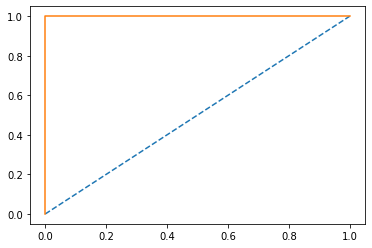

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
prob tensor([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')


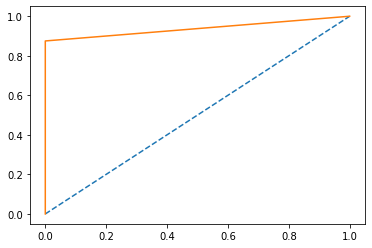

roc 0.9375
acc1 tensor(0.9375, device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')


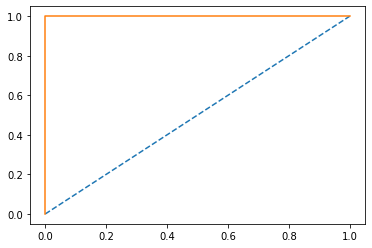

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


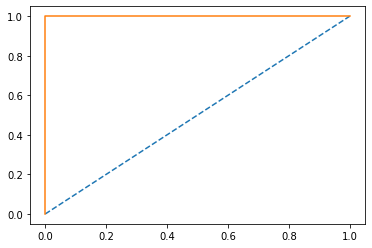

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')


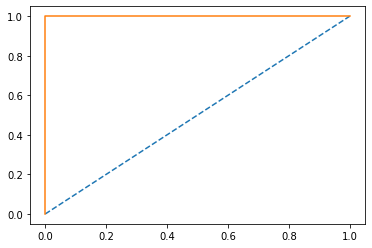

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')


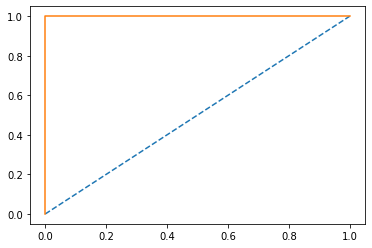

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')


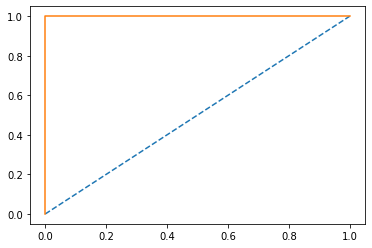

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')


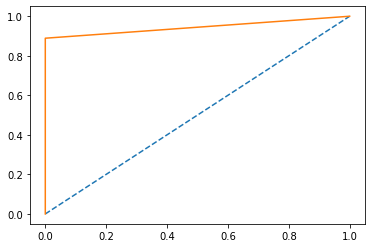

roc 0.9444444444444444
acc1 tensor(0.9375, device='cuda:0')
pred tensor([1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')


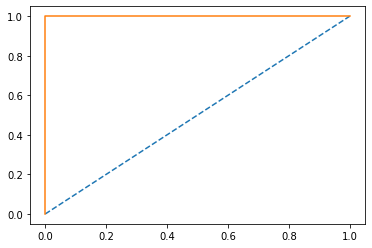

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')


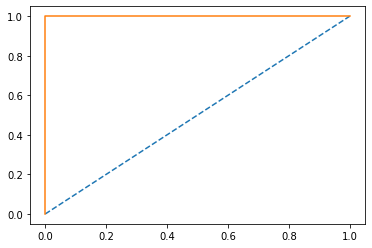

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')


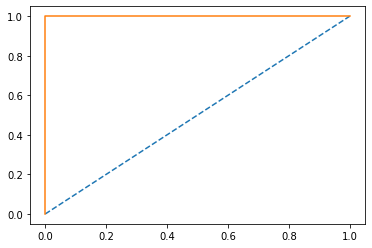

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
prob tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')


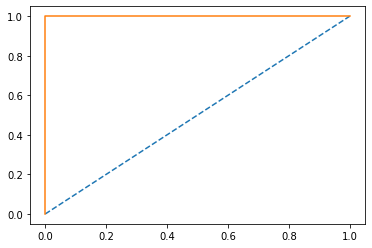

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
prob tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')


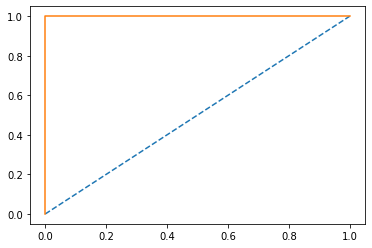

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
prob tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')


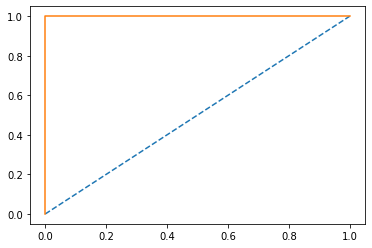

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')


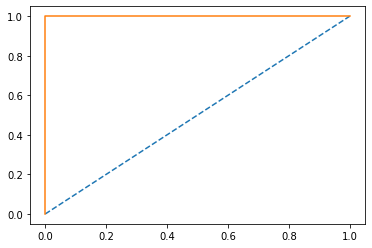

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')


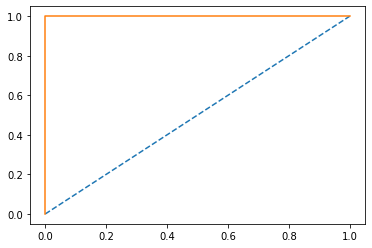

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')


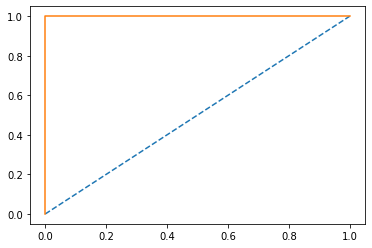

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')


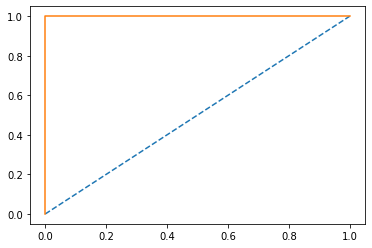

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
prob tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')


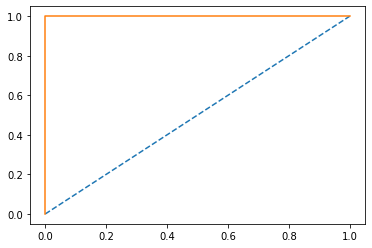

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')


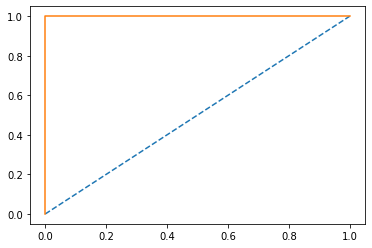

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
prob tensor([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')


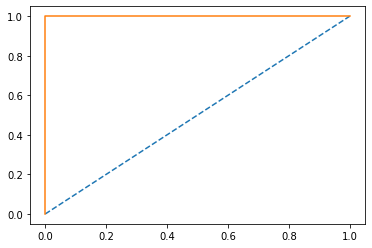

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
prob tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')


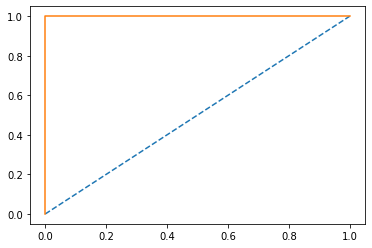

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')


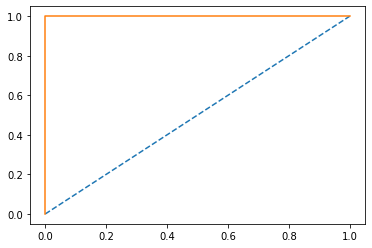

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
prob tensor([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')


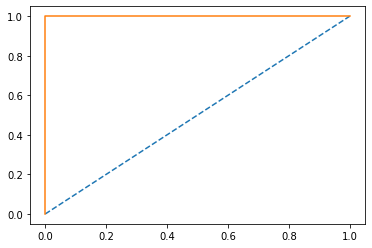

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
prob tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')


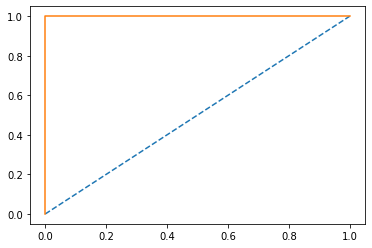

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')


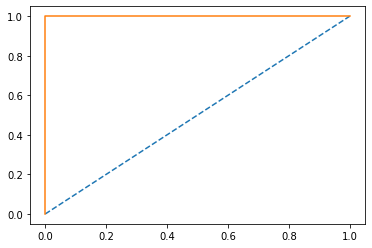

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')


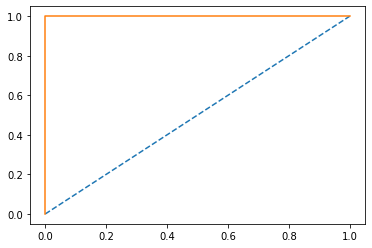

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')


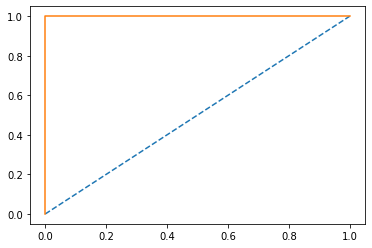

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')


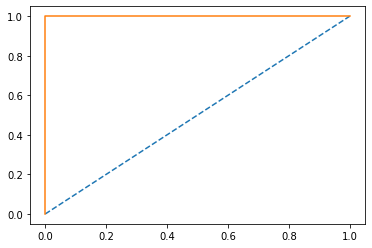

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
prob tensor([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')


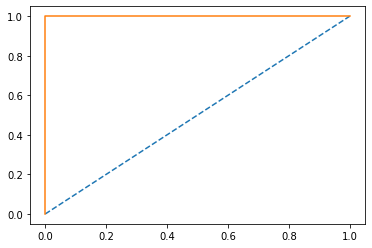

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')


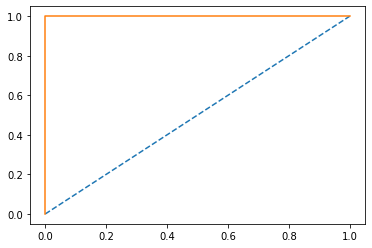

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')


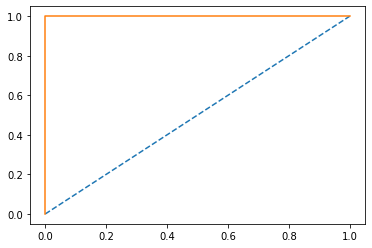

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')


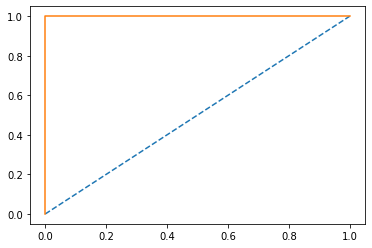

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')


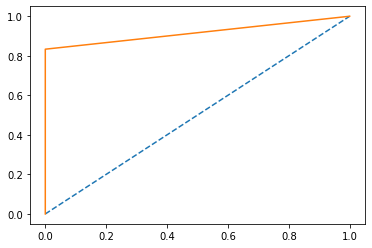

roc 0.9166666666666667
acc1 tensor(0.9375, device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')


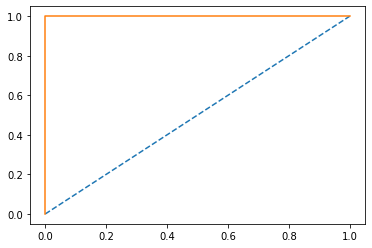

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')


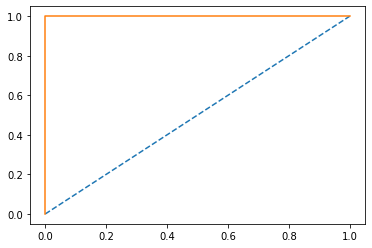

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
prob tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')


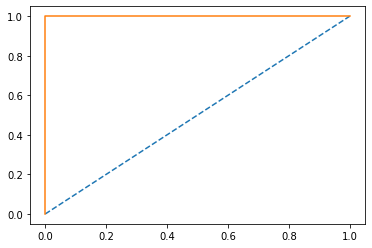

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
prob tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')


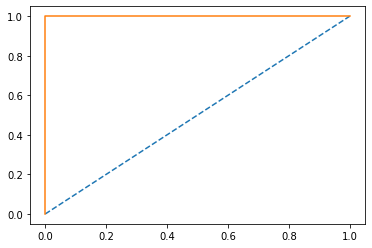

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')


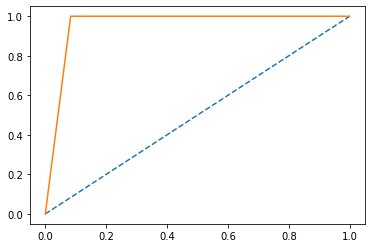

roc 0.9583333333333333
acc1 tensor(0.9375, device='cuda:0')
pred tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
prob tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')


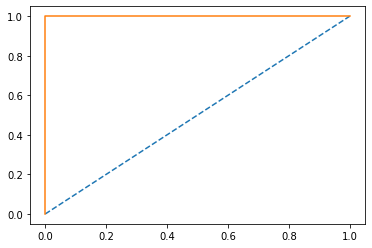

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')


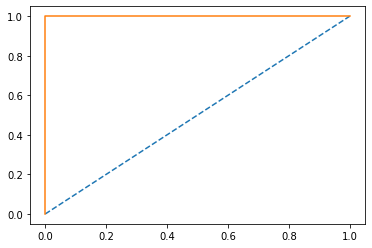

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')


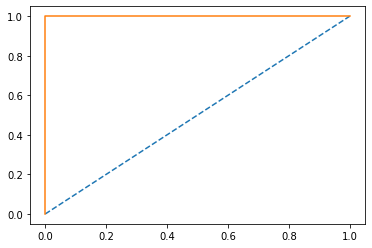

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')


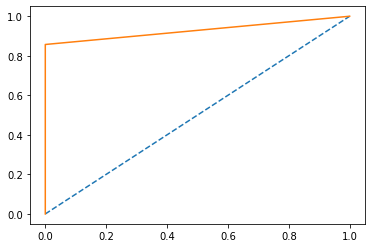

roc 0.9285714285714286
acc1 tensor(0.9375, device='cuda:0')
pred tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')


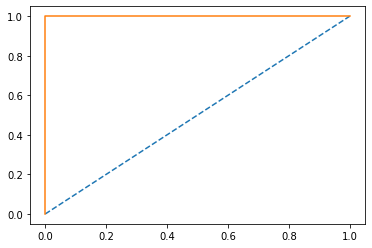

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')


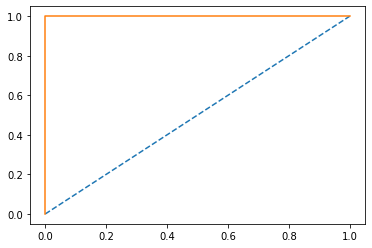

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')


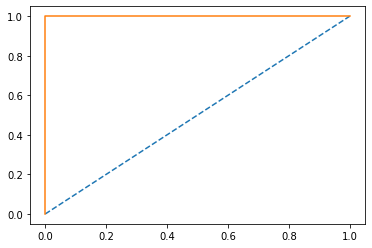

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')


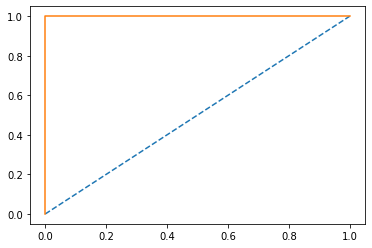

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')


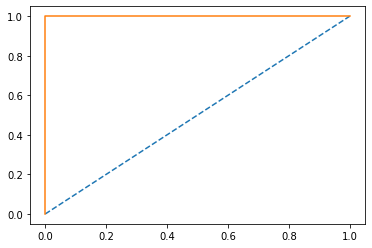

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')


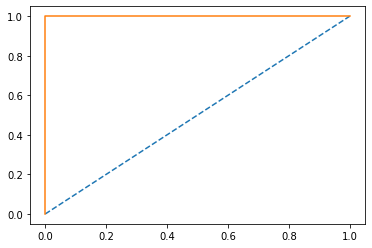

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
prob tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')


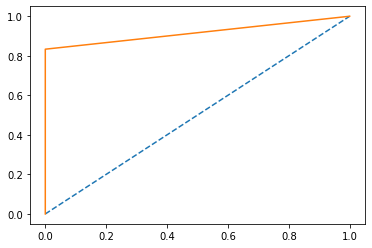

roc 0.9166666666666667
acc1 tensor(0.8750, device='cuda:0')
pred tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
prob tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')


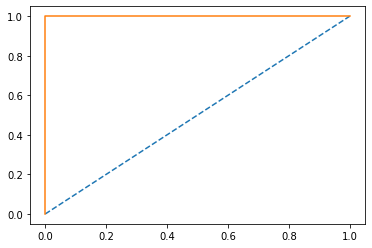

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
prob tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')


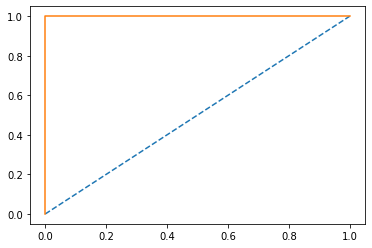

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
prob tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')


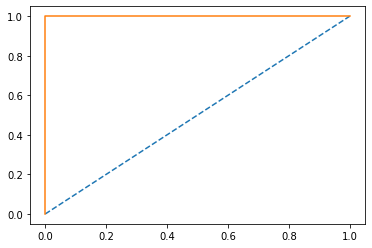

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
prob tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')


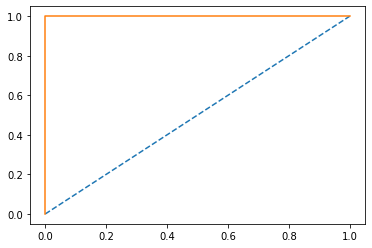

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')


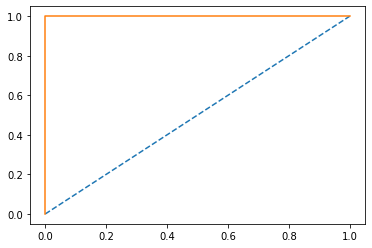

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')


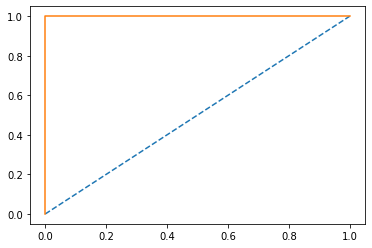

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')


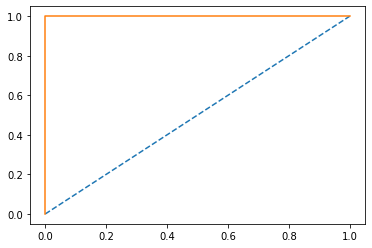

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')


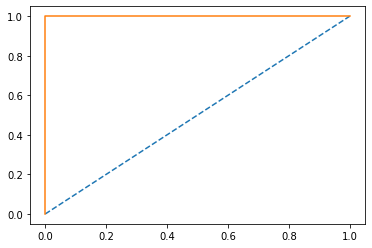

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')


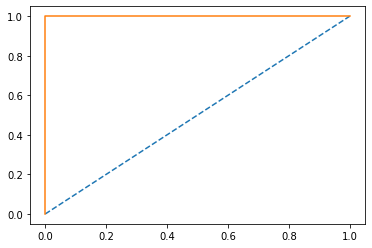

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')


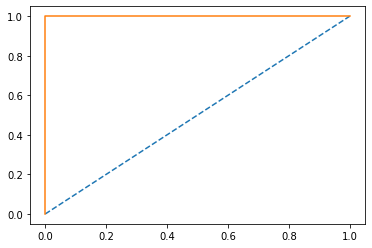

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')


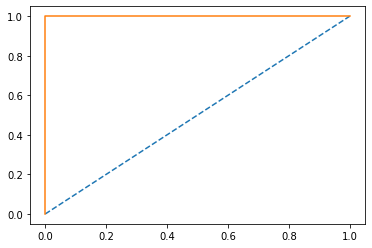

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')


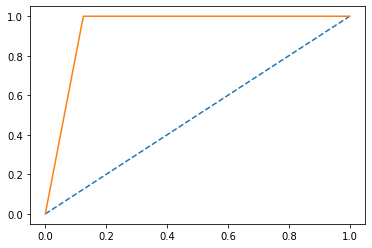

roc 0.9375
acc1 tensor(0.9375, device='cuda:0')
pred tensor([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
prob tensor([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')


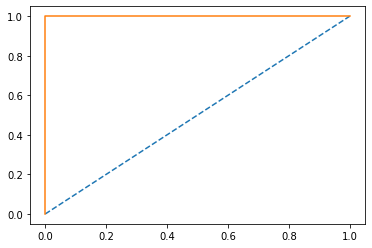

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')


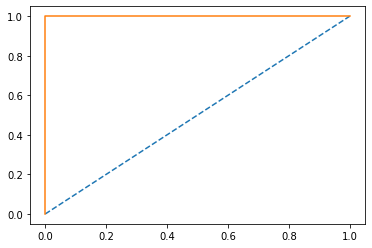

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


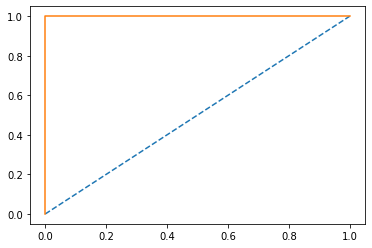

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')


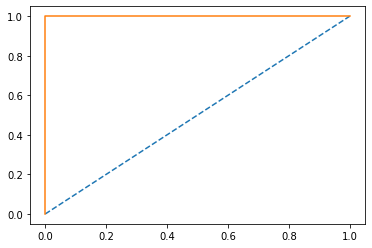

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')


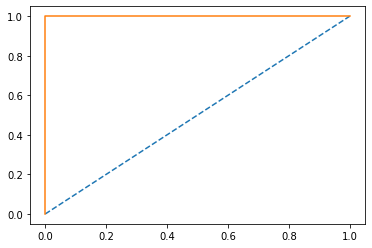

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
prob tensor([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')


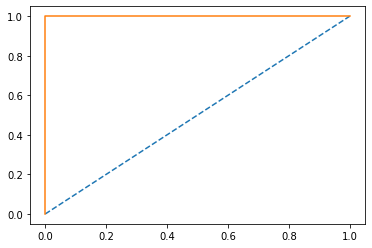

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')


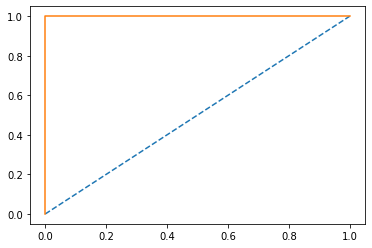

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')


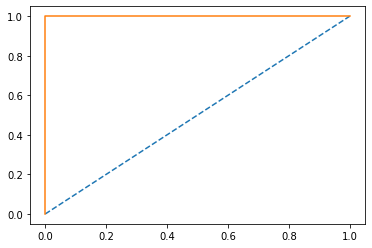

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
prob tensor([1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')


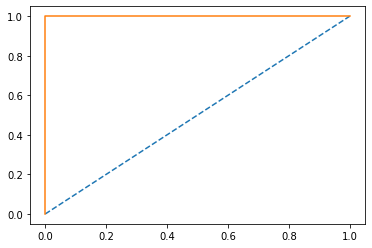

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
prob tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')


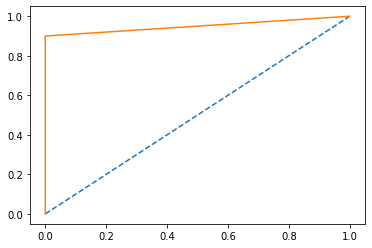

roc 0.95
acc1 tensor(0.9375, device='cuda:0')
pred tensor([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
prob tensor([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')


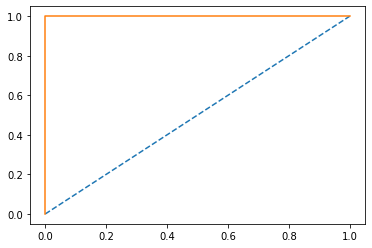

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')


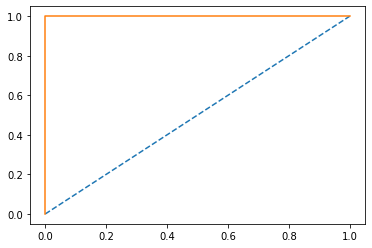

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')


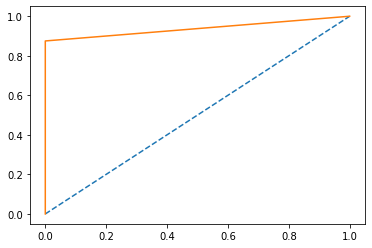

roc 0.9375
acc1 tensor(0.9375, device='cuda:0')
pred tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')


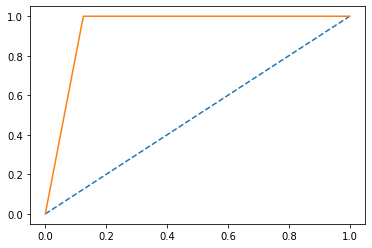

roc 0.9375
acc1 tensor(0.9375, device='cuda:0')
pred tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')


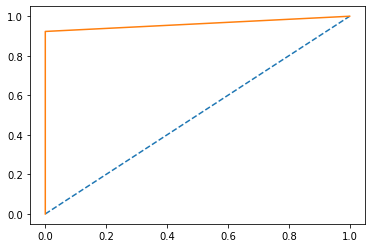

roc 0.9615384615384616
acc1 tensor(0.9375, device='cuda:0')
pred tensor([0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')


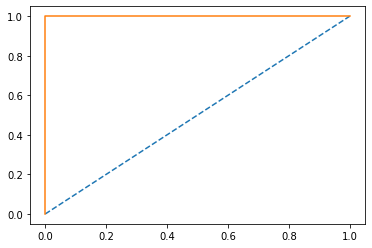

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')


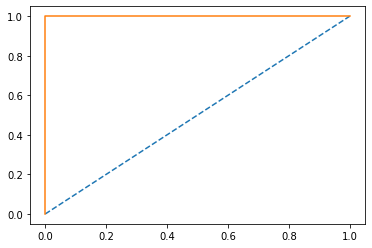

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')


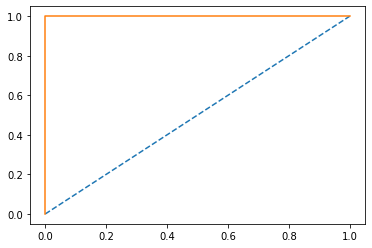

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')


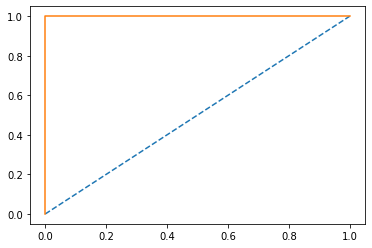

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')


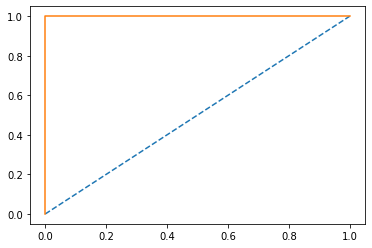

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')


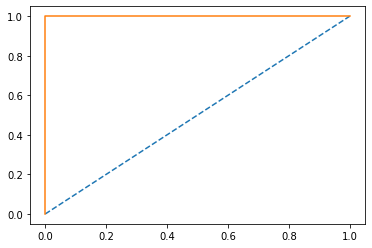

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')


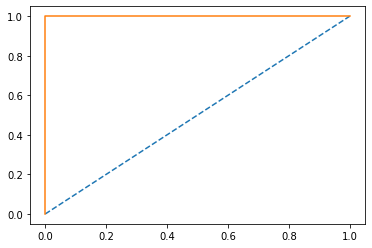

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')


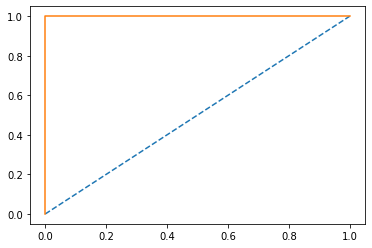

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')


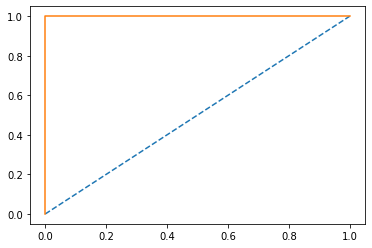

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')


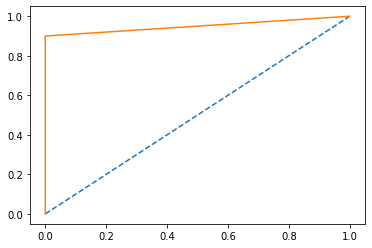

roc 0.95
acc1 tensor(0.9375, device='cuda:0')
pred tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')


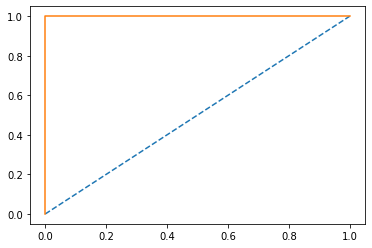

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')


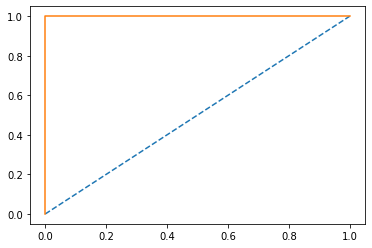

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')


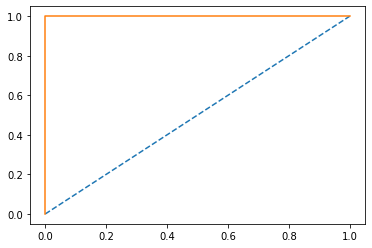

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')


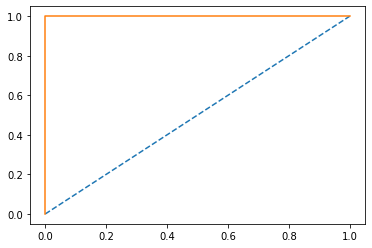

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')


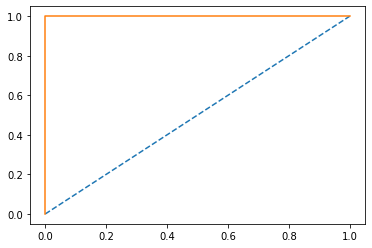

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
prob tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')


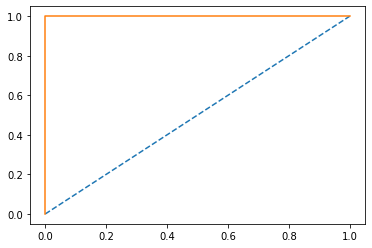

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')


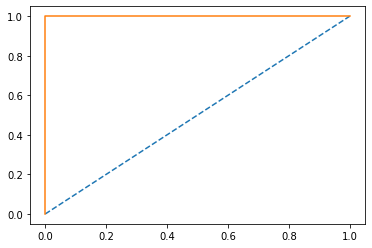

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
prob tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')


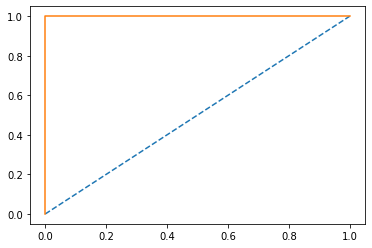

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')


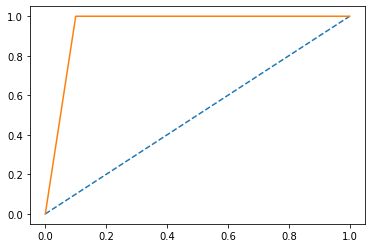

roc 0.9500000000000001
acc1 tensor(0.9375, device='cuda:0')
pred tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')


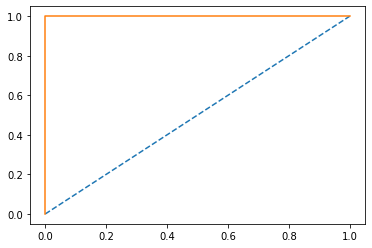

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
prob tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')


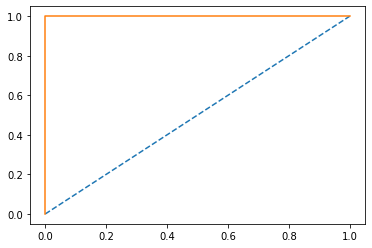

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')


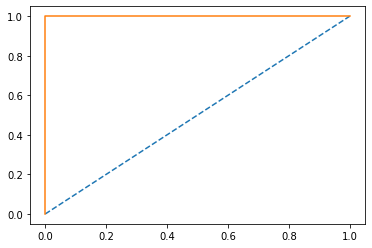

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
prob tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')


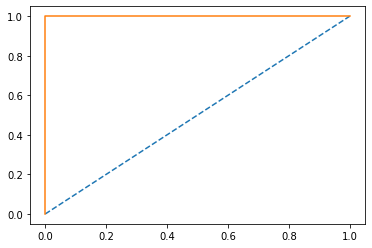

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')


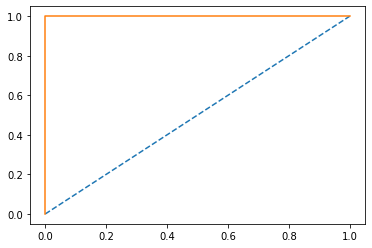

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')


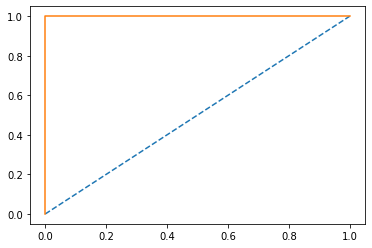

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


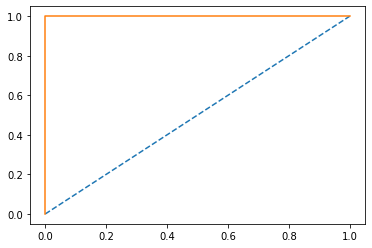

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')


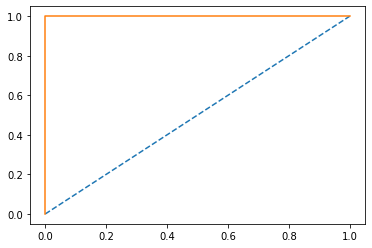

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
prob tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')


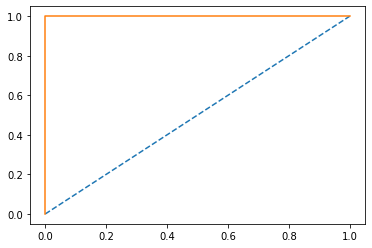

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
prob tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')


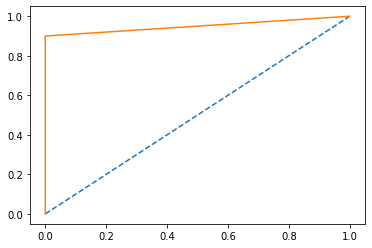

roc 0.95
acc1 tensor(0.9375, device='cuda:0')
pred tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
prob tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')


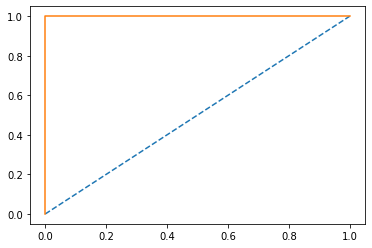

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([0, 0, 1], device='cuda:0')
prob tensor([0, 0, 1], device='cuda:0')


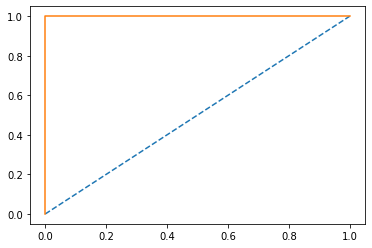

roc 1.0
acc1 tensor(1., device='cuda:0')
pred tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')


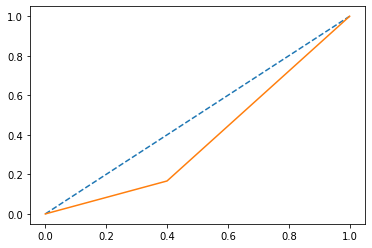

roc 0.38333333333333336
pred tensor([0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
prob tensor([0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')


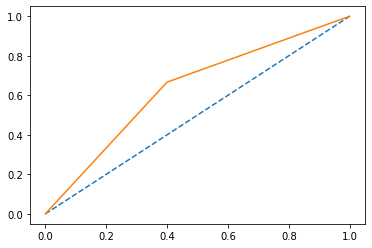

roc 0.6333333333333333
pred tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')


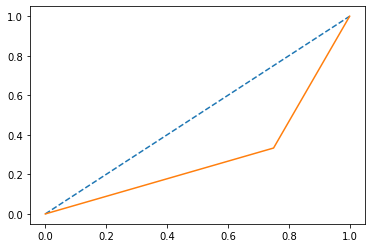

roc 0.29166666666666663
pred tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')


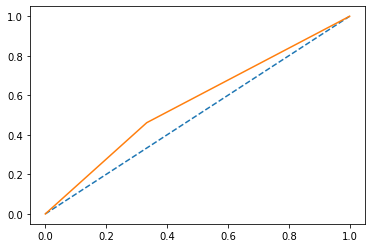

roc 0.5641025641025642
pred tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')


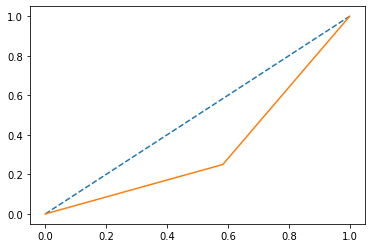

roc 0.3333333333333333
pred tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')


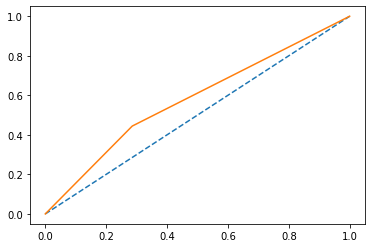

roc 0.5793650793650794
pred tensor([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


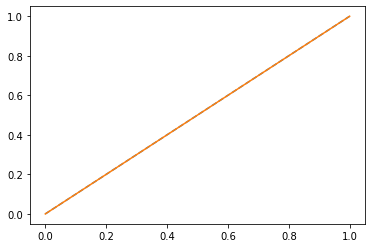

roc 0.5
pred tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')


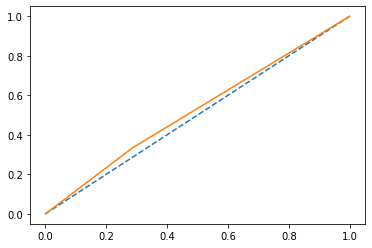

roc 0.5238095238095237
pred tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
prob tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')


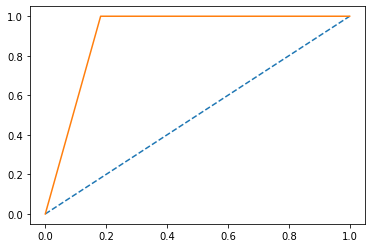

roc 0.9090909090909091
pred tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
prob tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')


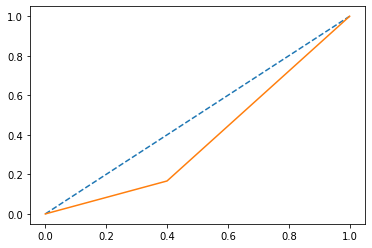

roc 0.38333333333333336
pred tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')


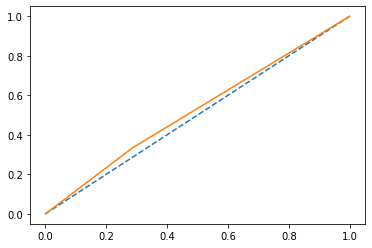

roc 0.5238095238095237
pred tensor([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')


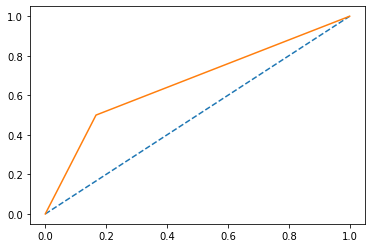

roc 0.6666666666666666
pred tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')


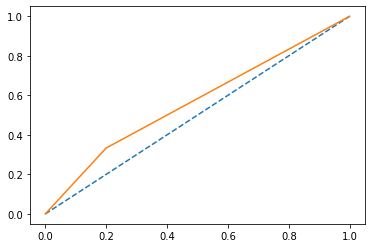

roc 0.5666666666666667
pred tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')


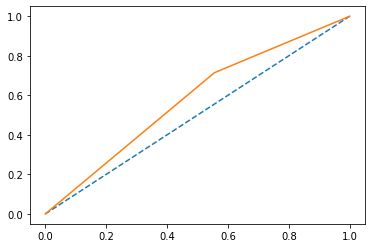

roc 0.5793650793650794
pred tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')


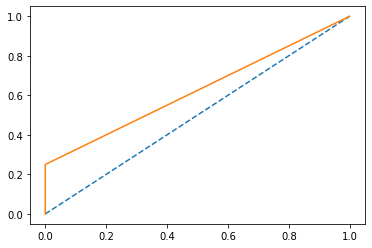

roc 0.625
pred tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
prob tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')


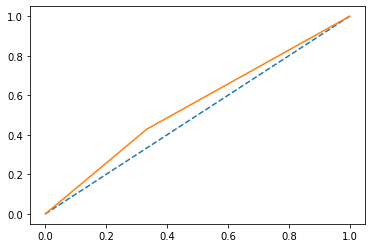

roc 0.5476190476190477
pred tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')


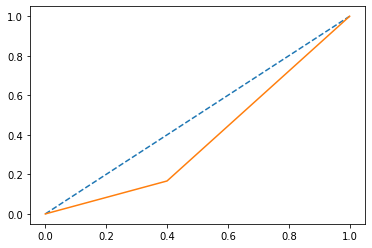

roc 0.38333333333333336
pred tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')


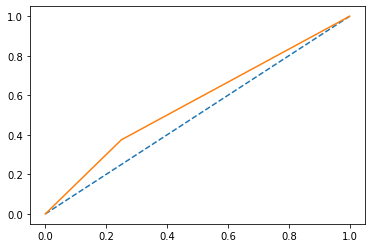

roc 0.5625
pred tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')


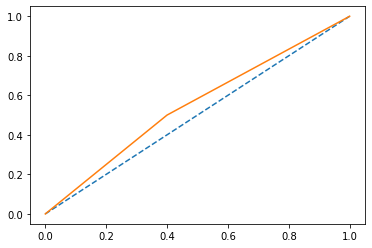

roc 0.5499999999999999
pred tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
prob tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')


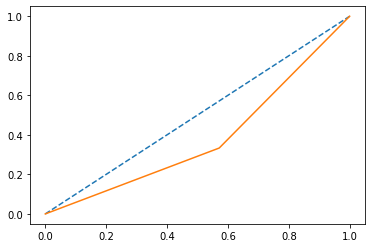

roc 0.38095238095238093
pred tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')


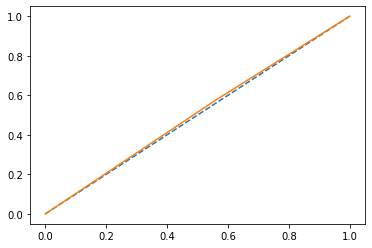

roc 0.5079365079365079
pred tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
prob tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')


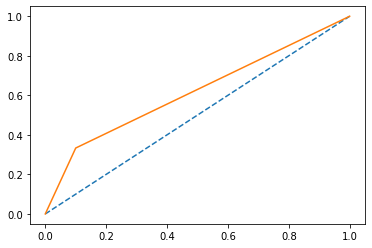

roc 0.6166666666666667
pred tensor([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
prob tensor([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')


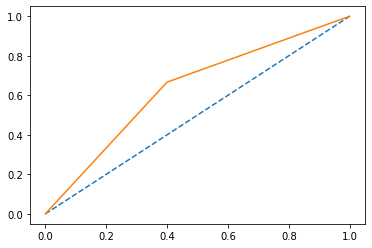

roc 0.6333333333333333
pred tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
prob tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')


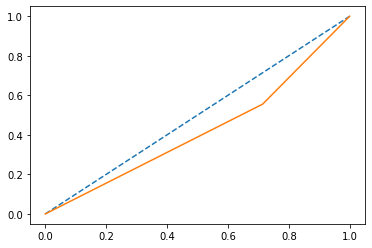

roc 0.42063492063492064
pred tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')


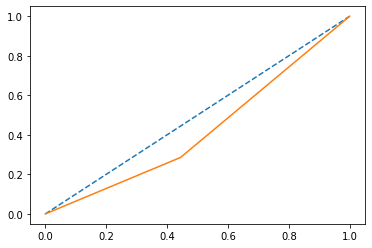

roc 0.42063492063492064
pred tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
prob tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')


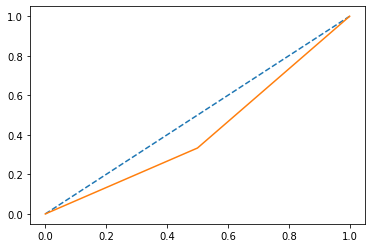

roc 0.41666666666666663
pred tensor([0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
prob tensor([0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')


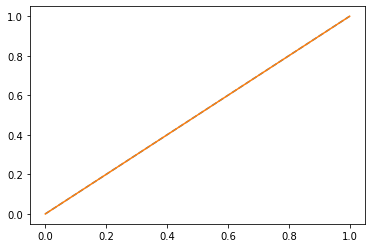

roc 0.5
pred tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')


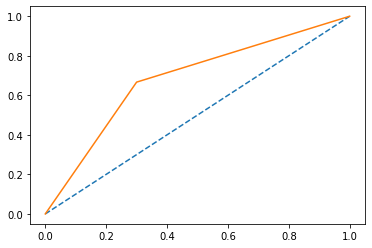

roc 0.6833333333333332
pred tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


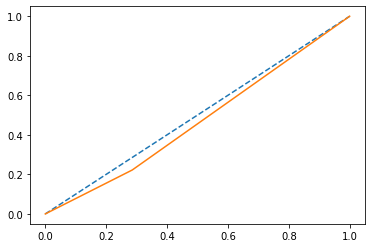

roc 0.4682539682539683
pred tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')


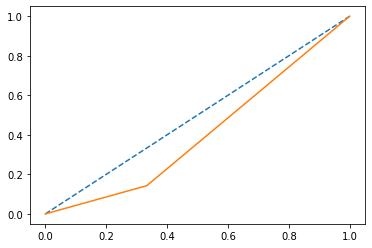

roc 0.40476190476190477
pred tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
prob tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')


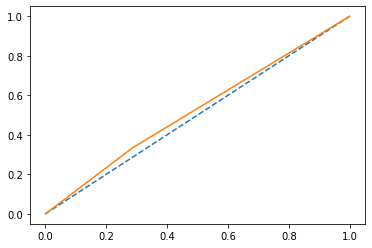

roc 0.5238095238095237
pred tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
prob tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


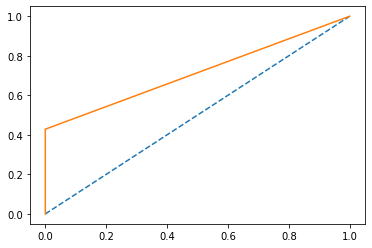

roc 0.7142857142857143
pred tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')


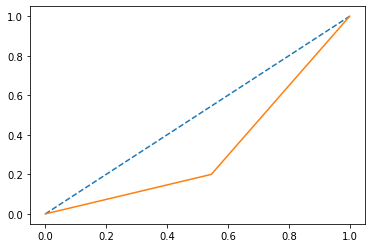

roc 0.3272727272727273
pred tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
prob tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')


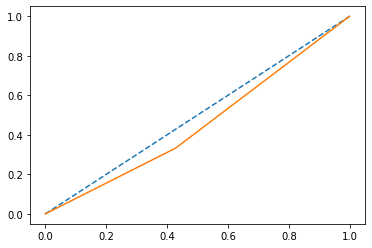

roc 0.45238095238095233
pred tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')


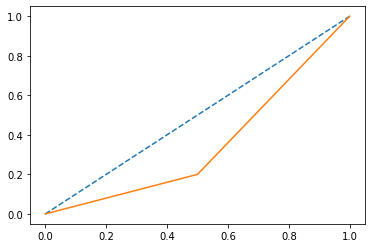

roc 0.35
pred tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
prob tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')


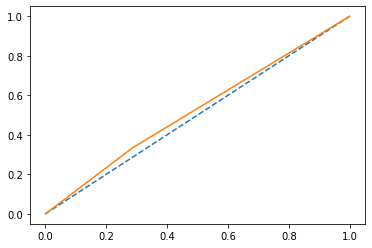

roc 0.5238095238095237
pred tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
prob tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')


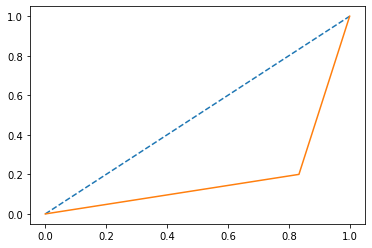

roc 0.18333333333333332
pred tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')


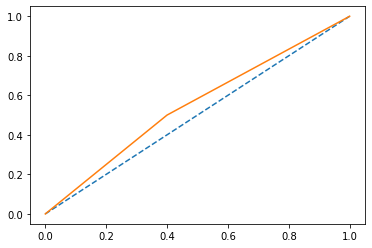

roc 0.5499999999999999
pred tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')


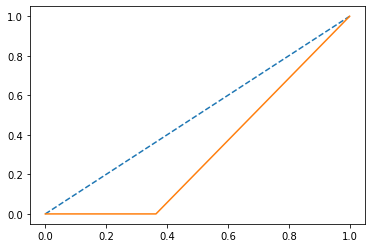

roc 0.3181818181818182
pred tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
prob tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')


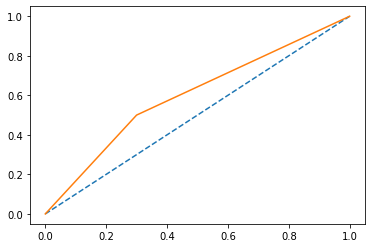

roc 0.5999999999999999
pred tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
prob tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')


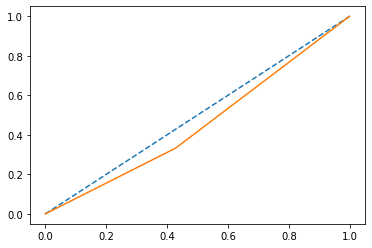

roc 0.45238095238095233
pred tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
prob tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')


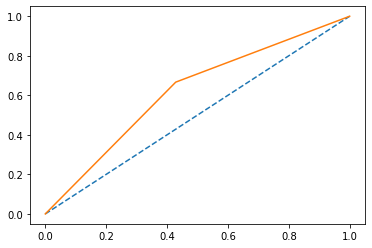

roc 0.619047619047619
pred tensor([1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
prob tensor([1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')


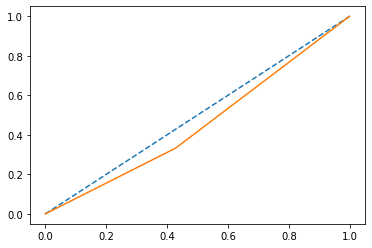

roc 0.45238095238095233
pred tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
prob tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')


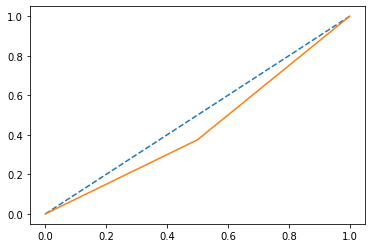

roc 0.4375
pred tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
prob tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')


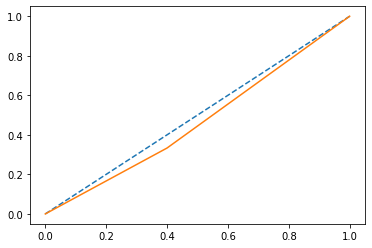

roc 0.4666666666666666
pred tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
prob tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')


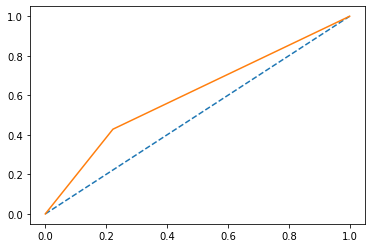

roc 0.6031746031746033
pred tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
prob tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')


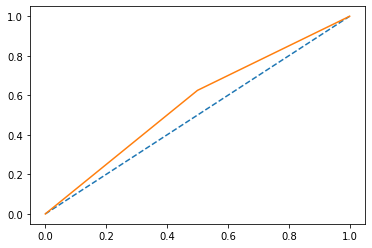

roc 0.5625
pred tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
prob tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')


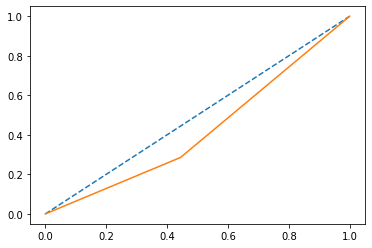

roc 0.42063492063492064
pred tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
prob tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')


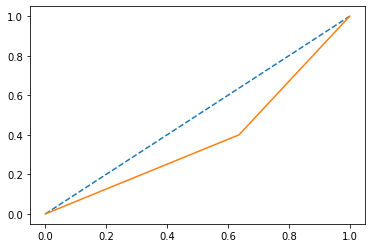

roc 0.38181818181818183
pred tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
prob tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')


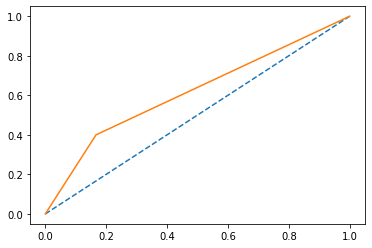

roc 0.6166666666666667
pred tensor([1], device='cuda:0')
prob tensor([1], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


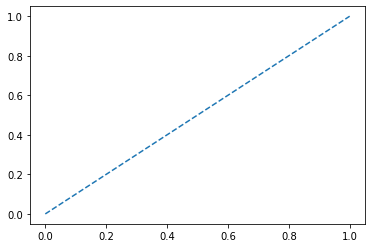

Epoch 1: train_loss: 0.0358 train_acc: 0.9907 | val_loss: 2.0651 val_acc: 0.4951
00:01:33.98
roc 506479067834546.2
num 2251799813685246
avg 0.22492188904024008


In [ ]:
train(model, train_loader, val_loader, optimizer)